<center><center>
    
# Defect detection in electroluminescence images of solar modules
    
## W281 Computer Vision Final Project 

### Aswin Thiruvengadam, Alexander To, Andi Morey Peterson, and Dan Ortiz

## Abstract

The detection of anomalies and defects within images is an important application of computer vision for manufacturers and researchers. It enables fast, repeatable, and automated identification and measurement of defects. In this project, we developed techniques to identify common manufacturing defects found in electroluminescence solar modules and solar cell images, taken from a commercial manufacturing line and made publicly available for research and development.    

Electroluminescence (EL) is a physical property of semiconductor materials whereby photons are emitted from the bulk semiconductor material as a result of radiative recombination induced by an applied external electric field. This process is commonly used in digital watches and car dashboards for night time display illumination. It is also used as an imaging and inspection technique in solar cell manufacturing as the map of radiative recombination across the device can reveal manufacturing defects in the solar cell and/or module not visible to the human eye. The purpose of this project is to  analyze EL images of silicon solar cells in order to detect and classify common defects discovered in production.

## The Data

Our dataset consists of a publicly available dataset of 16,808 real and 256 simulated images of solar cells (17,064 individual images in total), sourced from 368 full module images via cropping. The 16,808 real images are taken from a publicly available dataset, which was recently published as part of a study of various semantic segmentation models used to highlight the defective regions within each image, where present. Some summary details of the dataset are provided below.
    
The images were captured using either a 16 MM CMOS sensor with a 950 nm long-pass filter, or a 8 MP Si CCD sensor with 850 nm long-pass filter. The long pass filter is used to filter any background signal unrelated to the radiative emission from the sample.

Each image is in jpeg format with each cropped cell having dimension 406 x 406 pixels. As EL images measure ‘counts’, there are no color channels to these images as each image is effectively a map of luminescent intensity.  

A publicly available fork of the original repository can be accessed from:
https://github.com/atox120/UCF-EL-Defect

<span style="color:red">**TODO: Need to describe how we modified the images here.**</span>

## The Defects

<span style="color:red">**TODO: EDA Table of Defects Here**</span>

In [27]:
import os
import sys
import copy
import time
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))
import matplotlib.pyplot as plt

from app.utils import ImageWrapper
from app.custom import RemoveBusBars, Orient
from app.transforms import FFT, IFFT, CreateOnesMask, PCA
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure

In [2]:
def show_example_image(defect_class='None', seed=0):
    iml = ImageLoader()
    defect_categories = iml.defect_classes
    not_defect_class = [x for x in defect_categories if x != defect_class]

    defects = (DefectViewer() << (ImageLoader(defect_class=defect_class) << 10))
    all_others = (DefectViewer() << (ImageLoader(defect_class=not_defect_class) << 10))
    clean = (DefectViewer() << (ImageLoader(defect_class='None') << 10))

    single_defect = defects - all_others

    _ = Show(num_images=1, seed=seed) << single_defect
    
    return

### Front Grid Interruption

The Front Grid Interruption defect is best described as "darkened rectangles appearing along the printed metal fingers"
<span style="color:red">**TODO: Describe Front Grid Interruption Causes?**</span>

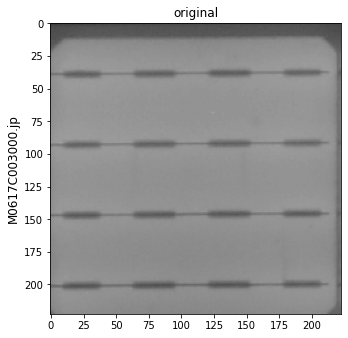

In [3]:
show_example_image('FrontGridInterruption', seed=16)

### Near Solder Pad

Near Solder Pad defects are very similar to Front Grid Interuption; however, these rectangles have a shaded region adjacent to the busbar. 
<span style="color:red">**TODO: Describe Near Solder Pad defect causes**</span>

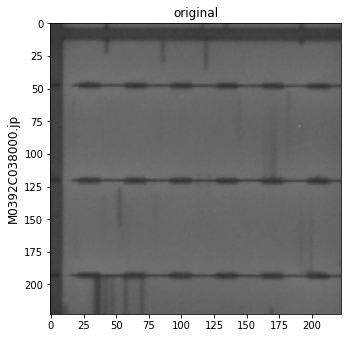

In [4]:
show_example_image('NearSolderPad', seed=93)

### Corrosion
Corrsion defects present as darkened regions starting at the busbar and extending perpendicularly along the finger, and typically extending farther from the centre than at the edges of the contact. 

<span style="color:red">**TODO: Describe Corrosion Defect Causes**</span>

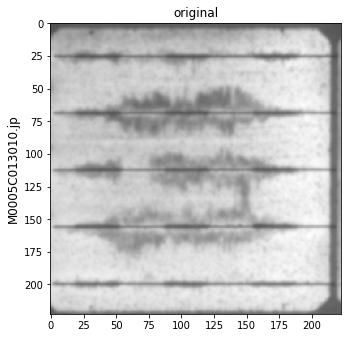

In [5]:
show_example_image('Corrosion', seed=1)

### Highly Resistive
Highly resistive interconnects are bright along portions of the busbar, and darkened along others. The longer the resistive region, the brighter the extended region perpendicular to the busbar, since the same amount of source current is not concentrated in a smaller area. 

<span style="color:red">**TODO: Describe Highly Resistive**</span>

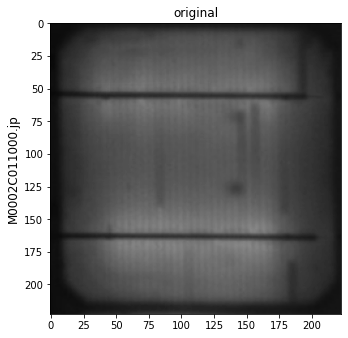

In [6]:
show_example_image('HighlyResistive', seed=1)

### Bright Spot
Bright spots are similiar to highly resistive but not always running along on the busbar. 
<span style="color:red">**TODO: Describe Bright Spot**</span>

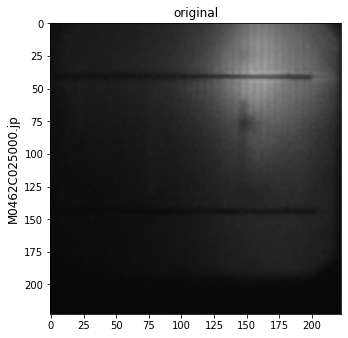

In [7]:
show_example_image('BrightSpot', seed=1)

### Resistive Cracks
Resistive crack category is one of three types of crack defects. Theis crack, resistive cracks, is determined by arkened regions extending from closed crack line or have a gradient intensity which is darkest at the crack edge.


<span style="color:red">**TODO: Describe Resistive Cracks**</span>

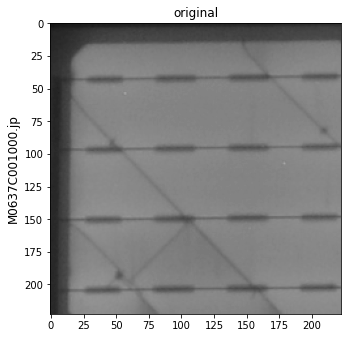

In [8]:
show_example_image('Resistive', seed=1)

### Closed Cracks
Closed cracks are the simple scracks of the bunch.  They are descipted as having black narrow lines in the image.
<span style="color:red">**TODO: Describe Closed Cracks**</span>

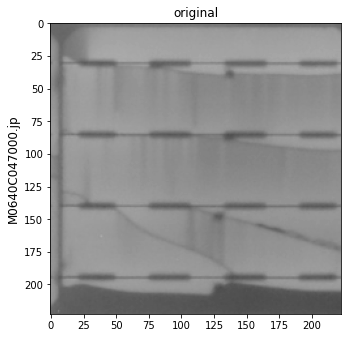

In [9]:
show_example_image('Closed', seed=1)

### Isolated Cracks
Isolated cracks are cracks which separate/isolate two individual sections of the cell with darkerend regions extending from the crack. They also have a uniform intensity across the darkened regions. 

<span style="color:red">**TODO: Describe Isolated Cracks**</span>

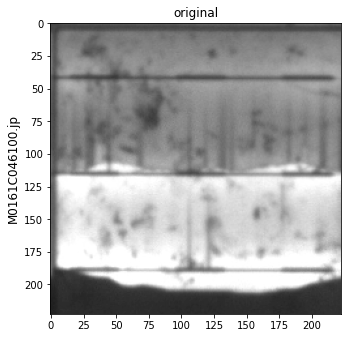

In [10]:
show_example_image('Isolated', seed=1)

## Feature Detection

### Front Grid Interruption

In [11]:
### Aswin to add here

### NearSolderPad

In [12]:
### Andi to add here (unless she's cracked the $h*ts)

### Corrosion

Due to the similar nature of the corrosion defect from one image to the other, and because it occurs on all of the busbars when the defect occurs, removing the busbars was not recommended.  Instead, a Principal Component Analysis was completed to possibly reduce dimensions. 

20 principal components explain 98.90 % of the total variance


Text(0, 0.5, 'Cumlative Explained Variance %')

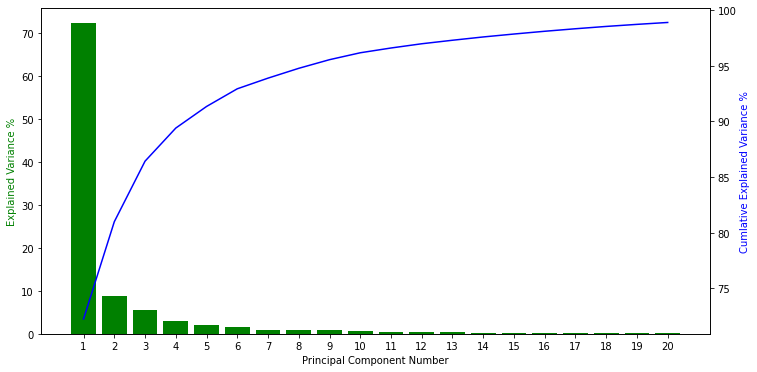

In [29]:
# Run PCA analysis on 20 components and plot the variance
n_components = 20
PCA_class_defect = PCA(transpose=True, n_components=n_components, whiten=True)

corrosion_defect_class='Corrosion'
corrosion_defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=corrosion_defect_class) << 100))
corrosion_defect.category = corrosion_defect_class

# Claculate the transform on the images
PCA_class_defect << corrosion_defect

# Total explained Variance
exp_var = PCA_class_defect.explained_variance_ratio[0]
total_exp_var = np.sum(exp_var)
print(f'{n} principal components explain {total_exp_var * 100:.2f} % of the total variance')

# Plot 

# Define X axis intervals:
x=np.arange(1, n_components + 1)
# Cumulative variance:
y1 = exp_var * 100
y2 = np.cumsum(y1)
    
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.bar(x, y1, color = 'g')
ax2.plot(x, y2, color = 'b')
    
ax1.set_xlabel('Principal Component Number')
ax1.set_xticks(x)
    
ax1.set_ylabel('Explained Variance %', color='g')
ax2.set_ylabel('Cumlative Explained Variance %', color='b')


Because the first component explained over 70% of the variance of the corrosion images, a cosine simialarity analysis was completed. 

In [ ]:
#Code for corrosion here

### Bright Spot

There are many options in Bright Spot feature detection - due to the high contrast nature of the spots in comparison to the background image of the solar cell. One method developed was to do a Fourier transform of the images extract the bright spot feature. 

Text(0.5, 1.0, 'Fourier Transform')

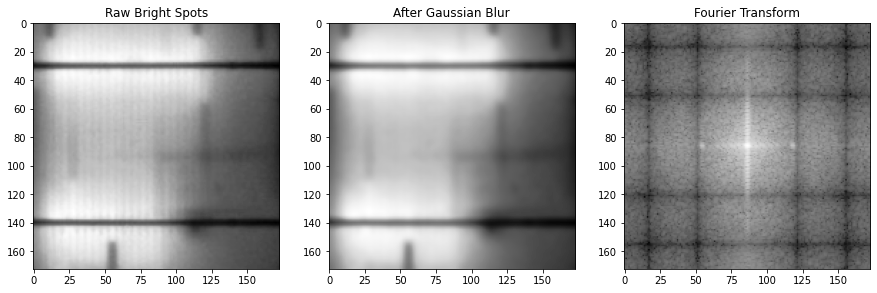

In [59]:
# Grab Brightspot Images

brightspot_defect_class='BrightSpot'
brightspot_defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=brightspot_defect_class) << 10))
brightspot_defect.category = brightspot_defect_class

# Mean Exposure and run a Gaussian Blur
brightspot_defect_blur = Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=5, std=8) << (Exposure('mean_norm') << brightspot_defect))
fourier_defect = (FFT(dim=2) << brightspot_defect_blur) 

# Plot images
plt.figure(figsize=(15, 24))
plt.subplot(131)
plt.imshow(brightspot_defect.images[1], cmap='Greys_r')
plt.title("Raw Bright Spots", size=12)
plt.subplot(132)
plt.imshow(brightspot_defect_blur[1].images[1], cmap='Greys_r')
plt.title("After Gaussian Blur", size=12)
plt.subplot(133)
plt.imshow(fourier_defect[-2].images[1], cmap='Greys_r')
plt.title("Fourier Transform", size=12)

### Resistive Cracks

In [15]:
### Dan to add here

### Closed Cracks

In [16]:
# Alex to add here

### Isolated Cracks

In [17]:
# Alex to add here

### Highly Resistive

In [18]:
# TBD to add here

# Classification Models

In [19]:
# TBD

# Results

In [20]:
# TBD

# Conclusion